In [582]:
import torch 
from torch import nn 
from sys import exit as e
import numpy as np
import math

from graphviz import Digraph

In [583]:

class Value:
  def __init__(self, data, _children=(), _op='', label='') -> None:
    self.data = data 
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None
  
  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad # Note: += accumulates gradients when a tensor undergoes multiple operations
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out


  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out
  
  def __truediv__(self, other):
    return self * other**-1

  def __rtruediv__(self, other): # other / self
        return other * self**-1

  def __rmul__(self, other):
    return self * other

  def __radd__(self, other):
    return self + other


  
  def exp(self):
    out = Value(math.exp(self.data), _children=(self, ), _op='exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "Supports only int/float powers for now."
    out = Value(self.data**other, _children=(self,), _op=f"**{other}")

    def _backward():
      self.grad += other * (self.data ** (other-1)) * out.grad
    out._backward = _backward

    return out
  
  def tanh(self):
    x = self.data 
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, _children=(self, ), _op='tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out
  
  def backward(self):
    topo = []
    visited = set()
    def build_topo(node):
      if node not in visited:
        visited.add(node)
        for children in node._prev:
          build_topo(children)
        topo.append(node)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3, label='b')
c = Value(10.0, label='c')
f = Value(-2., label='f')

d = a * b
d.label = 'd'

e = d + c 
e.label='e'

l = e * f 
l.label='l'

print(l)


Value(data=-8.0)


In [584]:
def trace(root):
  nodes, edges = set(), set()
  def build(root):
    if root not in nodes:
      nodes.add(root)

      for children in root._prev:
        edges.add((children, root))
        build(children)

  build(root)
  return nodes, edges

def draw_dot(root):
  nodes, edges = trace(root)
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  for n in nodes:
    # dot.node(str(id(n)), label=f"{n.label} | data: {n.data}", shape='record')
    dot.node(str(id(n)), label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name=str(id(n)) + n._op, label=n._op)
      dot.edge(str(id(n)) + n._op, str(id(n)))

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  
  return dot

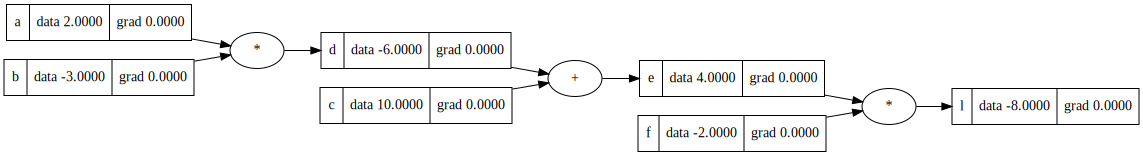

In [585]:
draw_dot(l)

## **SINGLE NEURON**

In [586]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

#x1w1 + x2w2 + b

x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'

n = x1w1x2w2 + b; n.label='n'

#-------------------------------
# o = n.tanh(); o.label='o'
e = (n*2).exp(); e.label='e'
o = (e - 1)/(e + 1)
#-------------------------------
print(n._prev)

{Value(data=-6.0), Value(data=6.881373587019543)}


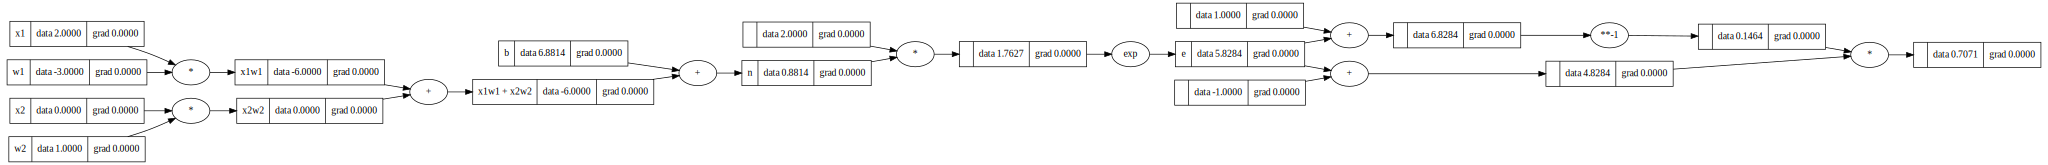

In [587]:
draw_dot(o)

In [588]:
o.backward()

## **TORCH LAND**

In [589]:
x1 = torch.tensor([2.0], dtype=torch.float64, requires_grad=True)
x2 = torch.tensor([0.0], dtype=torch.float64, requires_grad=True)
w1 = torch.tensor([-3.0], dtype=torch.float64, requires_grad=True)
w2 = torch.tensor([1.0], dtype=torch.float64, requires_grad=True)
b = torch.tensor([6.8813735870195432], dtype=torch.float64, requires_grad=True)

x1w1 = x1 * w1 
x2w2 = x2 * w2 
x1w1x2w2 = x1w1 + x2w2 
n = x1w1x2w2 + b 
o = torch.tanh(n)
print(o.item())

o.backward()

print(f"{x1.grad=}")
print(f"{x2.grad=}")
print(f"{w1.grad=}")
print(f"{w2.grad=}")
print(f"{b.grad=}")

0.7071067811865476
x1.grad=tensor([-1.5000], dtype=torch.float64)
x2.grad=tensor([0.5000], dtype=torch.float64)
w1.grad=tensor([1.0000], dtype=torch.float64)
w2.grad=tensor([0.], dtype=torch.float64)
b.grad=tensor([0.5000], dtype=torch.float64)


## **Stepping to MLP**

In [590]:
import random
class Neuron:
  def __init__(self, ndim):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(ndim)]
    self.b = Value(random.uniform(-1, 1))
  
  def __call__(self, x):
    act = sum((xi * wi for xi, wi in zip(x, self.w)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


class Layer:
  def __init__(self, ndim, nout):
    self.neurons = [Neuron(ndim) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    params = [p for neuron in self.neurons for p in neuron.parameters()]
    return params


class MLP:
  def __init__(self, ndim, nouts):
    nz =[ndim] + nouts
    self.layers = [Layer(nz[i], nz[i+1]) for i in range(len(nz)-1)]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
      # print(x)
    return x
  
  def parameters(self):
    params = [p for layer in self.layers for p in layer.parameters()]
    return params

In [591]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

model = MLP(3, [4, 4, 1])



In [612]:

for epoch in range(20):
  preds = [model(x) for x in xs]
  loss = sum([(pred - y)**2 for pred, y in zip(preds, ys)])

  for p in model.parameters():
    p.grad = 0.0
  loss.backward()
  for p in model.parameters():
    p.data += -0.5 * p.grad

  print(loss)


Value(data=0.0004153834822018756)
Value(data=0.0004119926935082282)
Value(data=0.00040865636821636124)
Value(data=0.0004053732102497217)
Value(data=0.000402141964226121)
Value(data=0.0003989614138757048)
Value(data=0.0003958303805320311)
Value(data=0.00039274772169242044)
Value(data=0.0003897123296438416)
Value(data=0.0003867231301509495)
Value(data=0.00038377908120290844)
Value(data=0.0003808791718161261)
Value(data=0.0003780224208897946)
Value(data=0.00037520787611177223)
Value(data=0.00037243461291204376)
Value(data=0.00036970173346151803)
Value(data=0.00036700836571376704)
Value(data=0.0003643536624876851)
Value(data=0.00036173680058894825)
Value(data=0.0003591569799684619)


In [613]:
preds

[Value(data=0.9910951828052571),
 Value(data=-0.9951209096163722),
 Value(data=-0.9899341137179192),
 Value(data=0.9875608030371217)]